<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/NN10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Detection
* Neural Network
* PyTorch

## Import Library

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [190]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Import Dataset

In [240]:
df = pd.read_csv("breast-cancer.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [241]:
df.isna().sum().any()

False

In [242]:
df["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

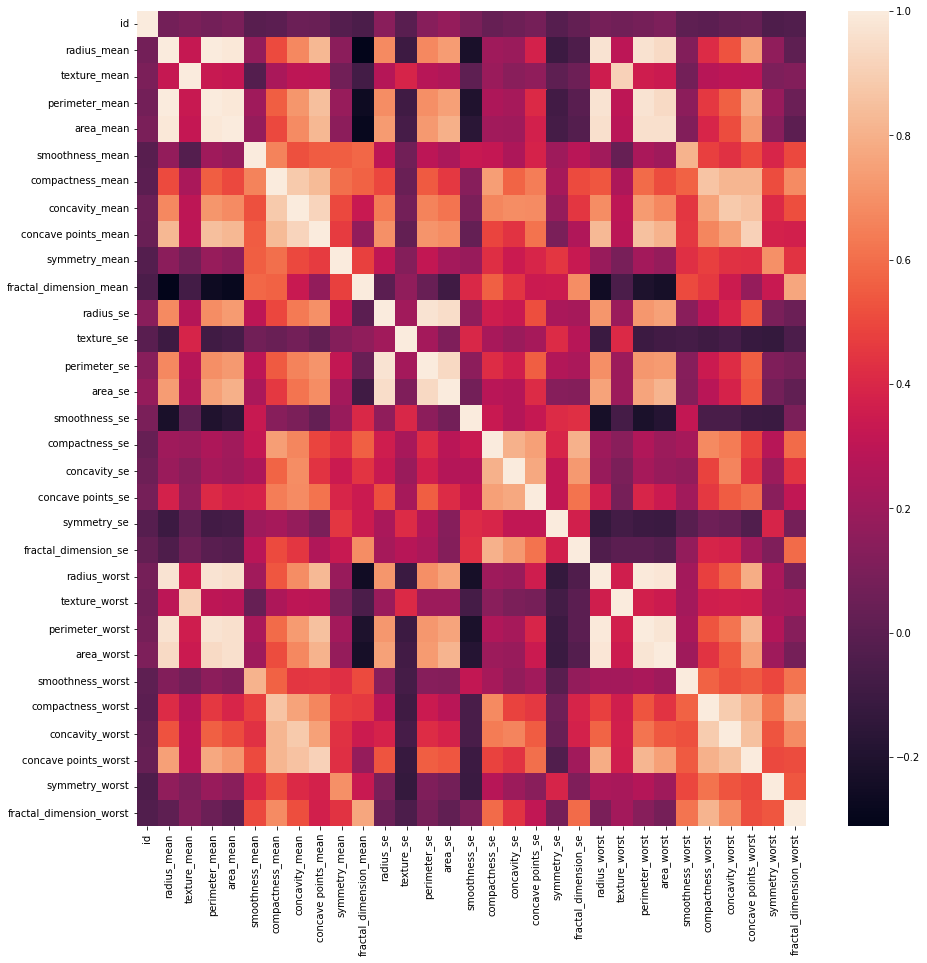

In [225]:
plt.figure(figsize=(15,15))
corr= df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [243]:
df.loc[df.diagnosis == "B", 'diagnosis'] = 0.
df.loc[df.diagnosis == "M", 'diagnosis'] = 1.

In [244]:
df["diagnosis"]=df.diagnosis.astype(float)

In [245]:
df= df.drop(["id"],1)

<ipython-input-245-df8aac4787fe>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df= df.drop(["id"],1)


In [246]:
df_train, df_test= train_test_split(df, test_size=0.1, random_state=42, shuffle=True)

In [247]:
df_train.shape, df_test.shape

((512, 31), (57, 31))

In [248]:
x= df_train.drop(["diagnosis"],1)
y= df_train["diagnosis"]

<ipython-input-248-f68b579bdd17>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x= df_train.drop(["diagnosis"],1)


In [249]:
x.shape, y.shape

((512, 30), (512,))

In [250]:
x= torch.from_numpy(x.values).type(dtype=torch.float)

In [251]:
y= torch.from_numpy(y.values).type(dtype=torch.float)

In [252]:
x.shape, y.shape

(torch.Size([512, 30]), torch.Size([512]))

In [253]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=0.1, random_state=42)

## Create Model

In [254]:
class BreastCancerModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers= nn.Sequential(
        nn.Linear(30, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,8),
        nn.ReLU(),
        nn.Linear(8,1)
    )
  def forward(self, x):
    x= self.layers(x)
    return(x)

In [255]:
model_0= BreastCancerModel().to(device)
model_0

BreastCancerModel(
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [256]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [257]:
def accuracy_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc= (correct/len(y_pred))*100
  return acc 

In [264]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  #Training Dataset
  model_0.train()
  #Forward Propaagation
  output = model_0(X_train).squeeze(dim=1)
  y_pred = torch.round(torch.sigmoid(output)) 
  #Loss and Accuracy Function
  loss= loss_fn(output, y_train)
  acc= accuracy_fn(y_train, y_pred)
  #optimizer zero grad
  optimizer.zero_grad()
  #Loss Back Propagation
  loss.backward()
  #optimizer step
  optimizer.step()

  #Testing Dataset
  model_0.eval()
  with torch.inference_mode():
    #Forward Propagation
    test_output=model_0(X_test).squeeze(dim=1)
    test_pred= torch.round(torch.sigmoid(test_output))
    #Loss and Accuracy Function
    test_loss= loss_fn(test_output, y_test)
    test_acc= accuracy_fn(y_test, test_pred)

  if epoch %10==0:
    print(f"Epoch: {epoch} | Loss: {loss} | Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}")


Epoch: 0 | Loss: 0.04401759058237076 | Acc: 97.82608695652173 | Test Loss: 0.21493695676326752 | Test Acc: 94.23076923076923
Epoch: 10 | Loss: 0.043614111840724945 | Acc: 97.82608695652173 | Test Loss: 0.21312445402145386 | Test Acc: 94.23076923076923
Epoch: 20 | Loss: 0.04311402887105942 | Acc: 98.04347826086956 | Test Loss: 0.21349142491817474 | Test Acc: 94.23076923076923
Epoch: 30 | Loss: 0.042720332741737366 | Acc: 97.82608695652173 | Test Loss: 0.21375159919261932 | Test Acc: 94.23076923076923
Epoch: 40 | Loss: 0.04242897406220436 | Acc: 98.04347826086956 | Test Loss: 0.21417005360126495 | Test Acc: 94.23076923076923
Epoch: 50 | Loss: 0.04211994633078575 | Acc: 97.82608695652173 | Test Loss: 0.2146587073802948 | Test Acc: 94.23076923076923
Epoch: 60 | Loss: 0.041681744158267975 | Acc: 98.04347826086956 | Test Loss: 0.2154921144247055 | Test Acc: 94.23076923076923
Epoch: 70 | Loss: 0.04138937219977379 | Acc: 98.04347826086956 | Test Loss: 0.2157406508922577 | Test Acc: 94.23076923

In [265]:
x_final_test = df_test.drop(["diagnosis"],1)
y_final_test = df_test["diagnosis"]

<ipython-input-265-ed6a3f8aa271>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_final_test = df_test.drop(["diagnosis"],1)


In [266]:
y_final_test.value_counts()

0.0    40
1.0    17
Name: diagnosis, dtype: int64

In [267]:
x_final_test =torch.from_numpy(x_final_test.values).type(dtype=torch.float)
y_final_test =torch.from_numpy(y_final_test.values).type(dtype=torch.float)

In [268]:
y_final_test.unique()

tensor([0., 1.])

In [269]:
torch.manual_seed(42)

#Set the number of epoch
epochs=1

x_final_test, y_final_test= x_final_test.to(device), y_final_test.to(device)

#Building training and evaluation loop:
for epoch in range(epochs):
  #Testing
  model_0.eval()
  with torch.inference_mode():

    ##Forward pass
    test_final_logits=model_0(x_final_test).squeeze()
    test_final_pred=torch.round(torch.sigmoid(test_final_logits))

    ##Claculate Test Loos/ Accuracy
    test_final_loss = loss_fn(test_final_logits, y_final_test) ##nn.BCEWithLogitsLoss expects raw logits as input
    test_final_acc = accuracy_fn(y_true=y_final_test, y_pred=test_final_pred)

  #Print th result
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Test loss: {test_final_loss:.5f}, Test acc: {test_final_acc:.2f}%")
    print(classification_report(y_final_test.to("cpu"), test_final_pred.to("cpu")))

Epoch: 0 | Test loss: 0.05846, Test acc: 96.49%
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98        40
         1.0       1.00      0.88      0.94        17

    accuracy                           0.96        57
   macro avg       0.98      0.94      0.96        57
weighted avg       0.97      0.96      0.96        57

